### Spatial Autocorrelation in 2010 Traffic Collisions

Using Week 8 Lab to detect clustering in collision location

hypothesis: clustering in areas dense with arterial roads and wider lanes

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

import folium
from folium import plugins
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import csv
import ast

In [2]:
gdf_tracts = gpd.read_file('Data/Census_Tracts_2020.geojson', crs='EPSG:4326')

In [3]:
gdf_bg = gpd.read_file('Data/Census_Tracts_2020.geojson', crs='EPSG:4326')

In [4]:
gdf_bounds_cityla = gpd.read_file('Data/acs2021_5yr_B01003_15000US060371041082-Copy1.geojson')
gdf_bg = gdf_bg.clip(gdf_bounds_cityla.geometry)

In [5]:
gdf_bg.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength',
       'geometry'],
      dtype='object')

<Axes: >

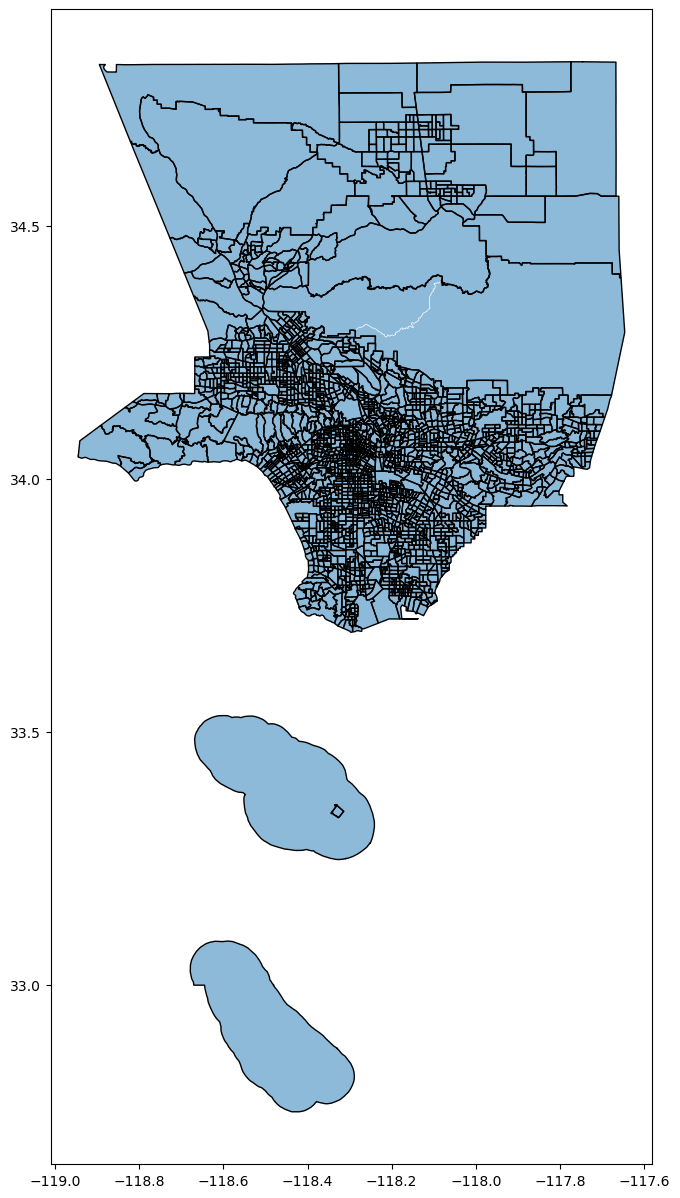

In [6]:
# compare
fig,ax = plt.subplots(figsize=(15,15))

# blue background of census tracts
gdf_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# while lines to show block groups (sandwiched between the two layers above for visual clarity)
gdf_bg.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)

# black boundary lines of census tracts on top of everything
gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

In [7]:
gdf_bg.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength',
       'geometry'],
      dtype='object')

In [8]:
pd.set_option('display.max_columns',None)
gdf_bg.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
1037,1038,276606,2766.06,2.334636e+06,7340.205444,"POLYGON ((-118.43857 33.95600, -118.43621 33.9..."
1036,1037,276605,2766.05,2.559688e+06,8205.751141,"POLYGON ((-118.43330 33.95709, -118.43323 33.9..."
1039,1040,276608,2766.08,3.878121e+06,8653.146156,"POLYGON ((-118.42698 33.95433, -118.42720 33.9..."
1045,1046,278102,2781.02,3.540357e+07,34681.313634,"POLYGON ((-118.43355 33.97417, -118.43354 33.9..."
1035,1036,276601,2766.01,2.410894e+07,23283.339996,"POLYGON ((-118.43223 33.97495, -118.43202 33.9..."


In [9]:
'''
print(gdf_bg['CT20'].min())
print(gdf_bg['CT20'].max())
gdf_bg.loc[gdf_bg['CT20']==gdf_bg['CT20'].max()].plot()
'''

"\nprint(gdf_bg['CT20'].min())\nprint(gdf_bg['CT20'].max())\ngdf_bg.loc[gdf_bg['CT20']==gdf_bg['CT20'].max()].plot()\n"

In [10]:
#gdf_bg.drop(gdf_bg.loc[gdf_bg['CT20']==gdf_bg['CT20'].max()].index,inplace=True)


In [11]:
'''
fig, ax = plt.subplots()
gdf_bg_large = gdf_bg.sort_values(by='CT20').tail(50)
gdf_bg_large.plot(ax=ax)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, crs=gdf_bg.crs.to_string())
'''

"\nfig, ax = plt.subplots()\ngdf_bg_large = gdf_bg.sort_values(by='CT20').tail(50)\ngdf_bg_large.plot(ax=ax)\nctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, crs=gdf_bg.crs.to_string())\n"

In [12]:
#gdf_bg.sort_values(by='POP20')

In [13]:
'''
fig,ax = plt.subplots(figsize=(15,15))

gdf_bg.plot(ax=ax,column= 'POP20',legend=True,alpha=0.8,cmap='RdYlGn_r',scheme = 'quantiles')

ax.axis('off')

ax.set_title('Population Count per Census Block Group')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
'''

"\nfig,ax = plt.subplots(figsize=(15,15))\n\ngdf_bg.plot(ax=ax,column= 'POP20',legend=True,alpha=0.8,cmap='RdYlGn_r',scheme = 'quantiles')\n\nax.axis('off')\n\nax.set_title('Population Count per Census Block Group')\nctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)\n"

In [14]:
df_10 = pd.read_csv('Data/2010_.csv',converters={"Location": ast.literal_eval})
gdf_10 = gpd.GeoDataFrame(df_10,crs='epsg:4326',
                       geometry=gpd.points_from_xy(df_10.Location.apply(lambda x: x[1]),df_10.Location.apply(lambda x: x[0])))
del(df_10)
gdf_10.drop(gdf_10.loc[gdf_10.geometry.x==0].index,inplace=True)


In [15]:
join_10 = gpd.sjoin(gdf_bg, gdf_10, how='left')
count_10 = join_10.CT20.value_counts().rename_axis('CT20').reset_index(name='collision_count_2010')
count_10.head()


,CT20,collision_count_2010
0,980028,269
1,226002,269
2,206051,219
3,190701,200
4,211000,177


In [16]:
gdf_bg = gdf_bg.merge(count_10,how='outer')

In [17]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf_bg,k=8)

# Row-standardization
wq.transform = 'r'

In [18]:
# create a new column for the spatial lag
gdf_bg['collision_count_2010_lag'] = lps.weights.lag_spatial(wq, gdf_bg['collision_count_2010'])

In [19]:
# take a look at some sample rows
#gdf_bg.sample(10)[['CT20','POP20','collision_count_2010','collision_count_2010_lag']]

In [20]:
# create a column that calculates the difference between arrests and lag
gdf_bg['collision_count_2010_lag_diff'] = gdf_bg['collision_count_2010'] - gdf_bg['collision_count_2010_lag']

In [21]:
# output to get the head and tail
gdf_bg.sort_values(by='collision_count_2010_lag_diff')

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,collision_count_2010,collision_count_2010_lag,collision_count_2010_lag_diff
179,2062,600100,6001.00,8.154795e+06,12355.028787,"MULTIPOLYGON (((-118.30027 33.95214, -118.3002...",1,67.000,-66.000
700,248,127803,1278.03,6.897436e+06,10521.746272,"POLYGON ((-118.44877 34.19937, -118.44877 34.1...",9,75.000,-66.000
938,606,207901,2079.01,2.188102e+06,6864.989107,"POLYGON ((-118.26564 34.03950, -118.26624 34.0...",20,84.375,-64.375
661,257,128220,1282.20,5.979977e+06,10040.053173,"POLYGON ((-118.43126 34.17988, -118.43195 34.1...",3,66.625,-63.625
905,2475,980016,9800.16,1.448453e+08,78269.935304,"MULTIPOLYGON (((-118.22302 34.01495, -118.2228...",1,55.750,-54.750
...,...,...,...,...,...,...,...,...,...
696,255,128102,1281.02,6.983275e+06,10570.697159,"POLYGON ((-118.43999 34.18667, -118.44218 34.1...",168,35.375,132.625
471,640,211000,2110.00,2.859668e+07,25170.331758,"POLYGON ((-118.32162 34.07620, -118.32063 34.0...",177,39.500,137.500
927,583,206051,2060.51,4.015774e+07,30027.529715,"POLYGON ((-118.22572 34.01532, -118.22751 34.0...",219,70.250,148.750
935,774,226002,2260.02,2.764534e+07,21400.411088,"POLYGON ((-118.24307 34.02360, -118.24322 34.0...",269,49.000,220.000


In [22]:
# the FIPS with highest negative difference
gdf_donut = gdf_bg.sort_values(by='collision_count_2010_lag_diff').head(1)
gdf_donut

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,collision_count_2010,collision_count_2010_lag,collision_count_2010_lag_diff
179,2062,600100,6001.00,8.154795e+06,12355.028787,"MULTIPOLYGON (((-118.30027 33.95214, -118.3002...",1,67.0,-66.0


In [23]:
# the FIPS with highest positive difference
gdf_diamond = gdf_bg.sort_values(by='collision_count_2010_lag_diff').tail(1)
gdf_diamond

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,collision_count_2010,collision_count_2010_lag,collision_count_2010_lag_diff
102,2486,980028,9800.28,2.119243e+08,85718.579965,"POLYGON ((-118.42223 33.91888, -118.42223 33.9...",269,11.375,257.625


In [24]:
# map the donut
gdf_donut.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [25]:
# map the diamond
gdf_diamond.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

/opt/conda/lib/python3.11/site-packages/contextily/tile.py:620: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


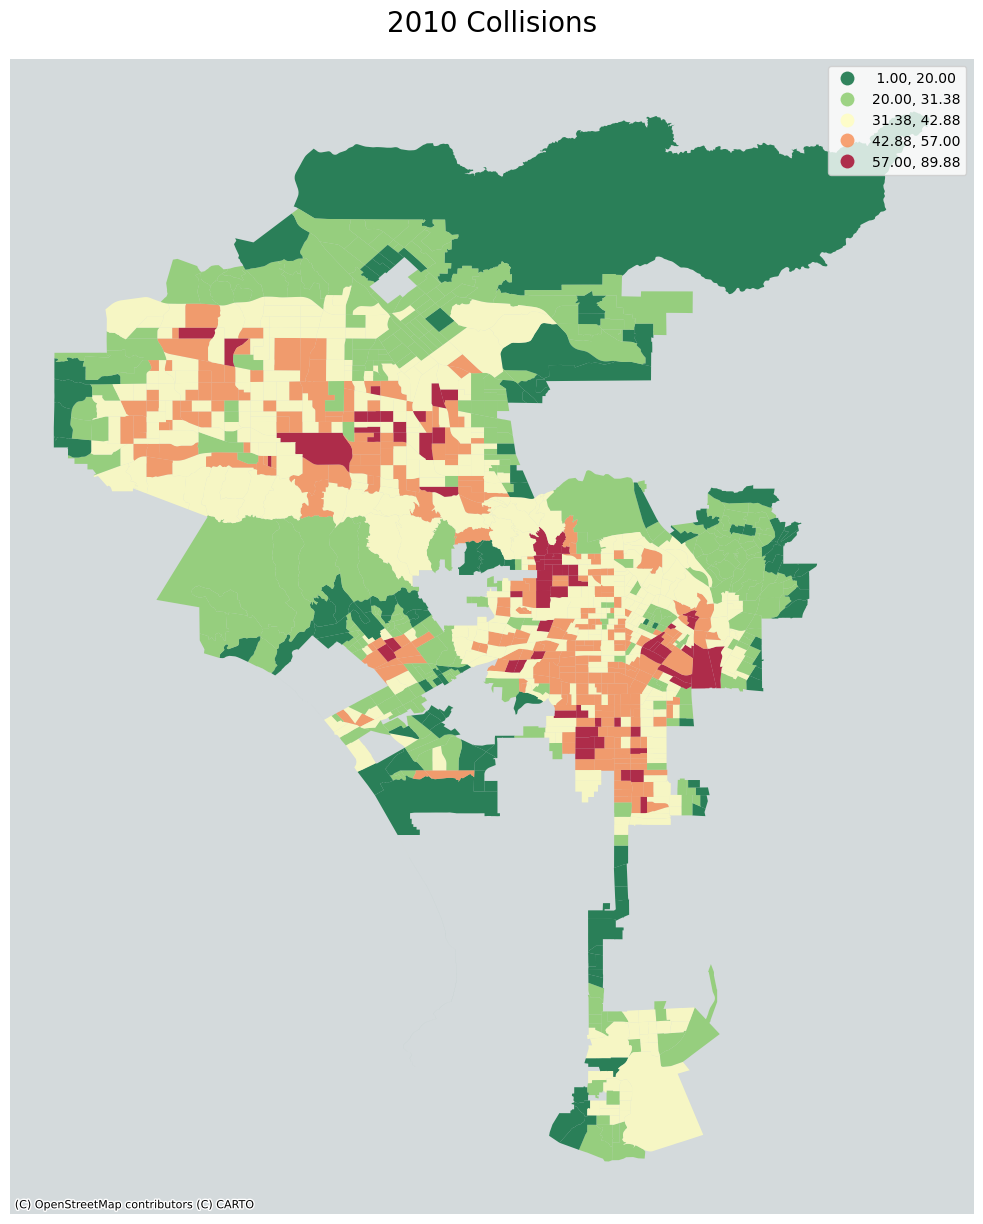

In [26]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
gdf_bg.plot(ax=ax,
         figsize=(15,15),
         column='collision_count_2010_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='NaturalBreaks')

ax.axis('off')
ax.set_title('2010 Collisions',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [27]:
'''
# a quick interactive version: geopandas .explore function does it all, no need to import folium!
gdf_bg.explore(
        column='collision_count_2010_lag', # this defines the field to "choropleth"
        legend=True,
        cmap='RdYlGn_r', # the "_r" reverses the color
        scheme='naturalbreaks',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )
'''

'\n# a quick interactive version: geopandas .explore function does it all, no need to import folium!\ngdf_bg.explore(\n        column=\'collision_count_2010_lag\', # this defines the field to "choropleth"\n        legend=True,\n        cmap=\'RdYlGn_r\', # the "_r" reverses the color\n        scheme=\'naturalbreaks\',\n        style_kwds={\n            \'weight\':0.5,\n            \'color\':\'black\',\n            \'opacity\':0.5\n        },\n        tiles=\'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}\',\n        attr=\'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community\'\n        )\n'

### Moran's Plot

In [28]:
y = gdf_bg.collision_count_2010
moran = Moran(y, wq)
moran.I

0.13832689653806415

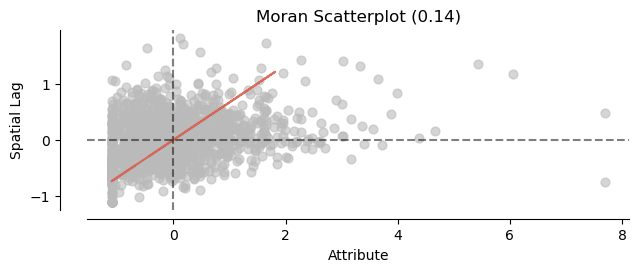

In [29]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.14', ylabel='Density'>)

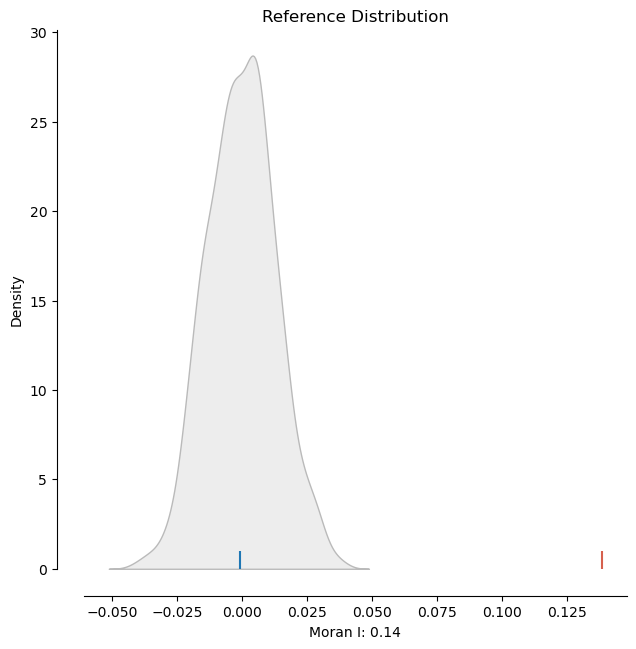

In [30]:
plot_moran_simulation(moran,aspect_equal=False)

In [31]:
moran.p_sim

0.001

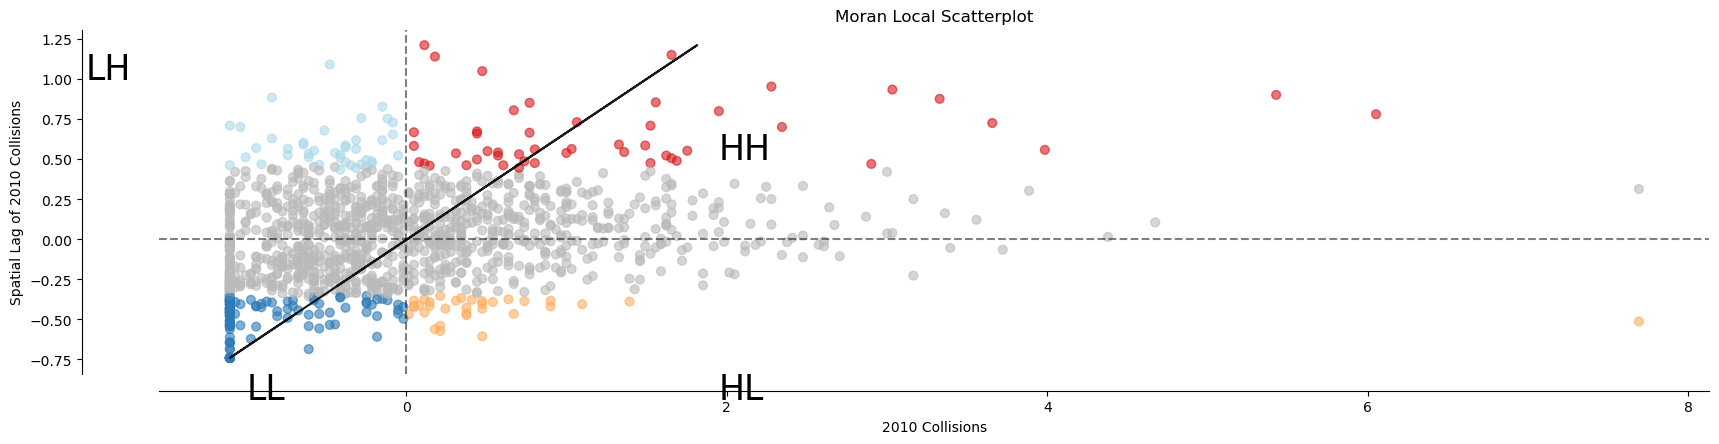

In [32]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("2010 Collisions")
ax.set_ylabel('Spatial Lag of 2010 Collisions')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

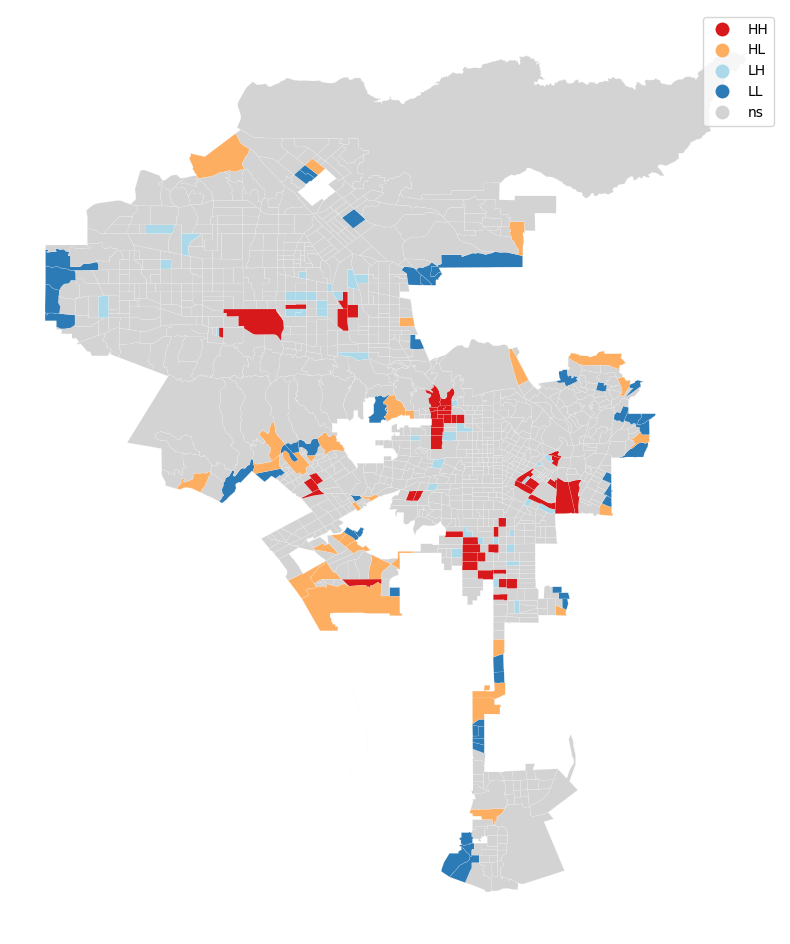

In [33]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_bg, p=0.05, ax=ax)
plt.show()

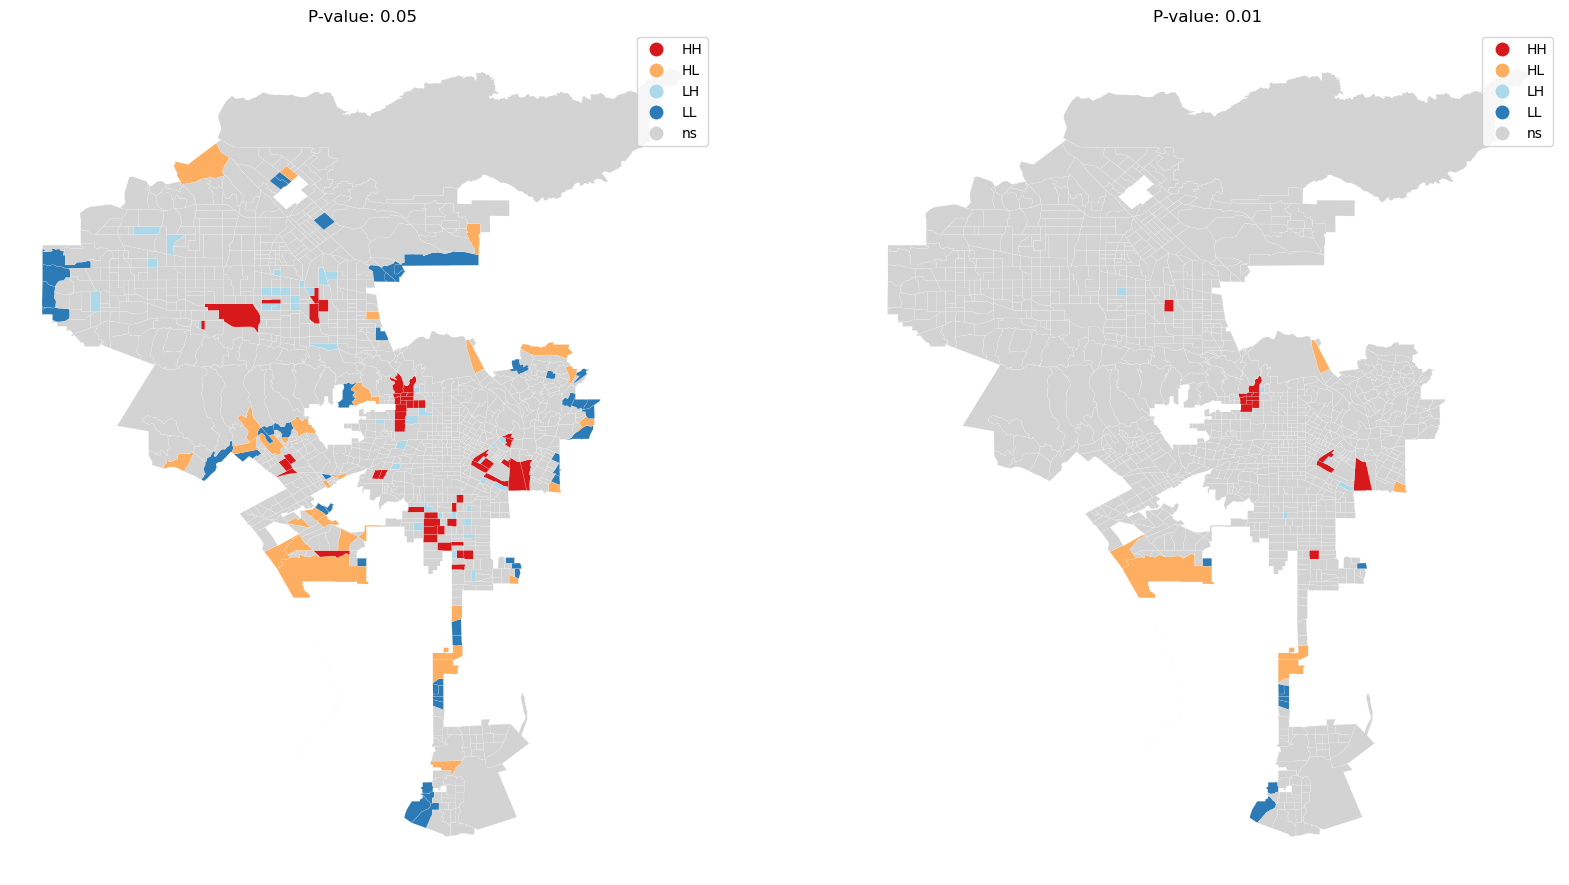

<Figure size 640x480 with 0 Axes>

In [34]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, gdf_bg, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, gdf_bg, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

plt.savefig('2010_Collision_Autocorrelation_LACounty_Tracts.png')